In [17]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle


In [19]:
warnings.filterwarnings("ignore")
scriptFolder = os.getcwd()  # current working directory
csvFile = "Admission_Predict.csv"
csvFilePath = os.path.join(scriptFolder, csvFile)
RegressorFile = "Predict.sav"
RegressorFilePath = os.path.join(scriptFolder, RegressorFile)

In [20]:
df = pd.read_csv("Admission_Predict.csv")
df.columns = df.columns.str.strip()

In [21]:
showDatasetInfo = True
showHistogram = True
showCorrelation = True
CrossVal = True
Eval = True
saveModel = True

In [22]:
if showDatasetInfo:
    print(Fore.GREEN, "\nDataset Columns:\n", Fore.RESET, df.columns)
    print(Fore.GREEN, "\nDataset Shape:\n", Fore.RESET, df.shape)
    print(Fore.GREEN, "\nDataset description:\n", Fore.RESET, df.describe())
    print(Fore.GREEN, "\nDataset Head:\n", Fore.RESET, df.head())

 
Dataset Columns:
  Index(['SerialNo', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')
 
Dataset Shape:
  (400, 9)
 
Dataset description:
           SerialNo   GRE Score  TOEFL Score  University Rating         SOP  \
count  400.000000  400.000000   400.000000         400.000000  400.000000   
mean   200.500000  316.807500   107.410000           3.087500    3.400000   
std    115.614301   11.473646     6.069514           1.143728    1.006869   
min      1.000000  290.000000    92.000000           1.000000    1.000000   
25%    100.750000  308.000000   103.000000           2.000000    2.500000   
50%    200.500000  317.000000   107.000000           3.000000    3.500000   
75%    300.250000  325.000000   112.000000           4.000000    4.000000   
max    400.000000  340.000000   120.000000           5.000000    5.000000   

              LOR        CGPA    Research  Chance of Admit  
count  400.000000  4

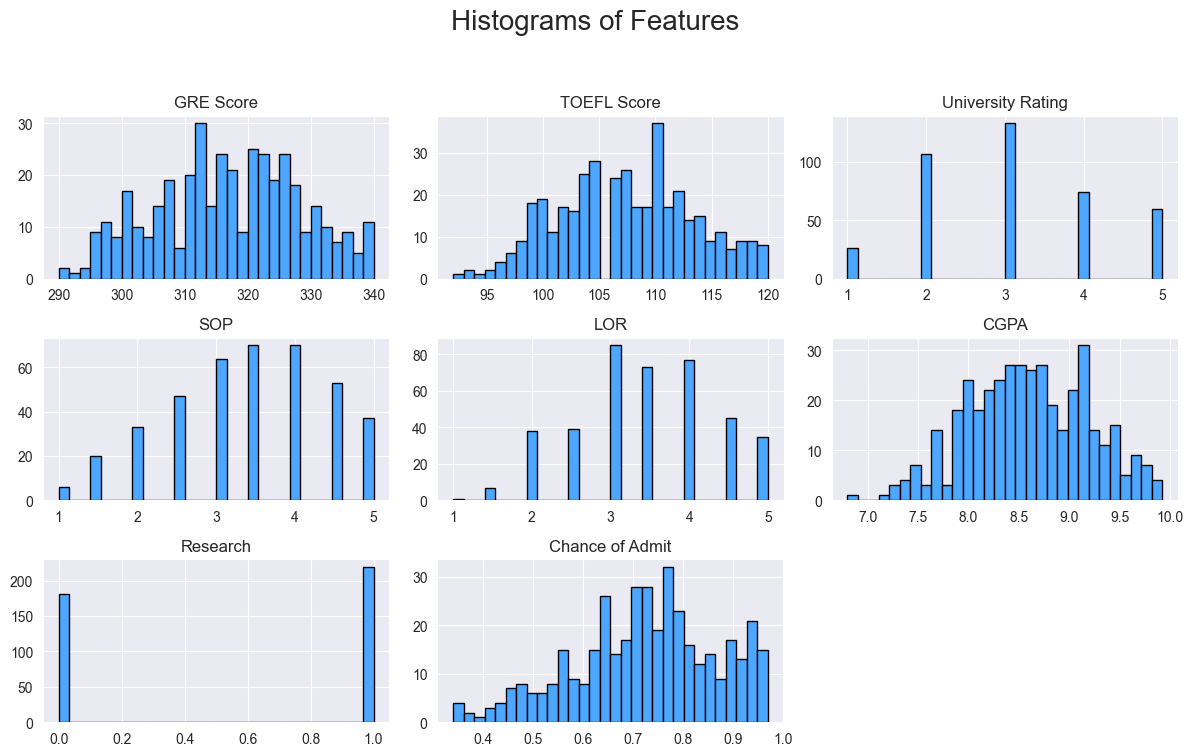

In [23]:
if showHistogram:
        histo = df.drop(columns=["SerialNo"])
        histo.hist(bins=30, edgecolor='black', color='#4da6ff', layout=(len(df.columns) // 3 + 1, 3),
                        figsize=(12,10))
        plt.suptitle("Histograms of Features", fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

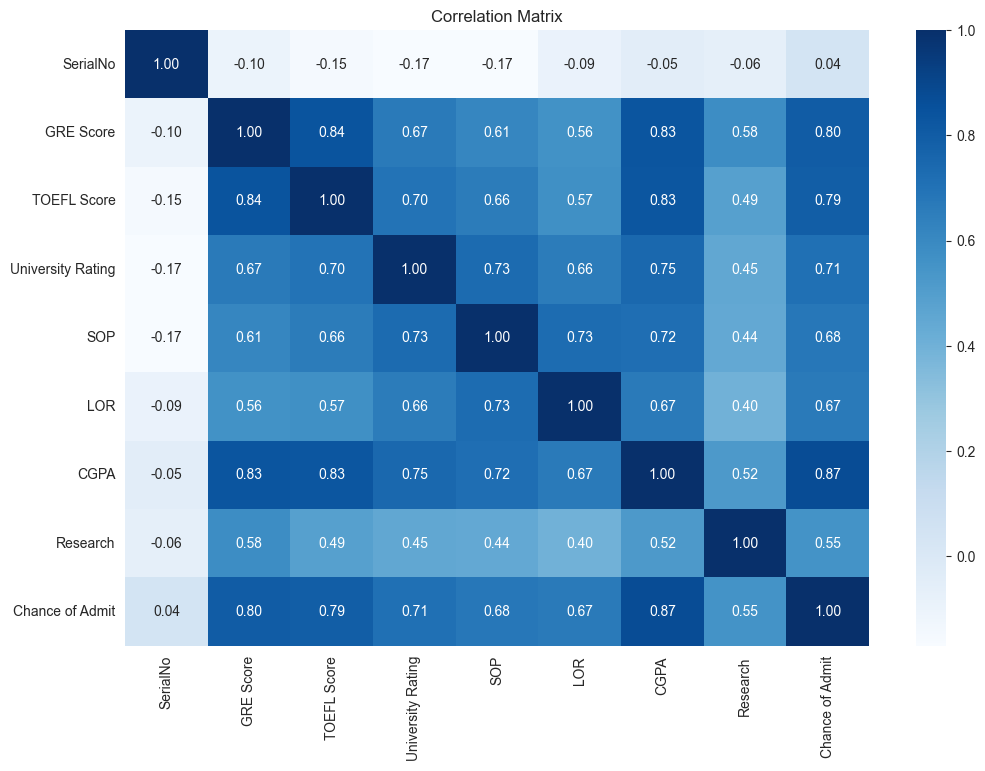

In [24]:
if showCorrelation:
    correlationMatrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlationMatrix, annot=True, cmap='Blues', fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

In [25]:
dataset = df.values
X = dataset[:, 0:8]
y = dataset[:, 8]
#Train-Test split
XTrain, XTest, yTrain, yTest = train_test_split(X,y, test_size=0.25, random_state=42)

In [26]:
regressors = [
    ("RF", "Random Forest", RandomForestRegressor(n_estimators=1000, random_state=42)),
    ("XGB", "Extreme Gradient Boosting", XGBRegressor()),
    ("CART", "Decision Tree", DecisionTreeRegressor()),
    ("SVM", "Support Vector Machine", SVR()),
    ("KNN", "K-Nearest Neighbour", KNeighborsRegressor()),
    ("MLR", "Multiple Linear Regression", LinearRegression())
]

In [27]:
results = []
# prepare repeated cross validation
if CrossVal:
    kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    for code, name, regressor in regressors:
        # determine the model's RMSE & standard deviation
        regressor.fit(XTrain, yTrain)
        scores = cross_val_score(regressor, XTrain, yTrain, cv=kfold, n_jobs=-1,
                                 scoring="neg_root_mean_squared_error")
        score = cross_val_score(regressor, XTrain, yTrain, cv=kfold, n_jobs=-1,
                                scoring = "r2")
        rmse = -scores.mean()  # RMSE: Root Mean Squared Error
        r2 = score.mean()
        standardDeviation = scores.std()

        # store the result in the results list
        results.append((code, name, regressor, round(rmse, 2), round(standardDeviation, 2), round(r2,2)))

    # sort results in ascending order of the 4th element (RMSE: Root Mean Squared Error)
    results.sort(key=lambda i: i[5], reverse = True)
    # display results
    p1 = round((len(XTrain) * 100) / len(X))  # training set percentage
    p2 = round((len(XTest) * 100) / len(X))  # test set percentage
    print("\n Regression Predictive Model: Admission Acceptance")
    print(" ---------------------------------------------------")
    print("   * Data Set Size: \t\t", len(X), "Records")
    print("\t Training Data Set Size:", len(XTrain), "Records (" + str(p1) + "%)")
    print("\t Test Data Set Size: \t", len(XTest), "Records (" + str(p2) + "%)")

    print("\n #   Regressor \t\t\t\t\t\t\t CV RMSE \t CV Standard Deviation\t\tCV R2 Score")
    print(" ------------------------------------------------------------------------------------------")
    i = 1
    for r in results:
        s = r[0] + " - " + r[1]
        print("", i, " ", s, (37 - len(s)) * " ", r[3], "\t\t", r[4], "\t\t\t\t\t", r[5])
        i += 1


 Regression Predictive Model: Admission Acceptance
 ---------------------------------------------------
   * Data Set Size: 		 400 Records
	 Training Data Set Size: 300 Records (75%)
	 Test Data Set Size: 	 100 Records (25%)

 #   Regressor 							 CV RMSE 	 CV Standard Deviation		CV R2 Score
 ------------------------------------------------------------------------------------------
 1   MLR - Multiple Linear Regression       0.06 		 0.01 					 0.79
 2   RF - Random Forest                     0.06 		 0.01 					 0.78
 3   XGB - Extreme Gradient Boosting        0.06 		 0.01 					 0.76
 4   KNN - K-Nearest Neighbour              0.07 		 0.01 					 0.69
 5   SVM - Support Vector Machine           0.08 		 0.01 					 0.62
 6   CART - Decision Tree                   0.09 		 0.02 					 0.56


In [28]:
results = []
if Eval:
    for code, name, regressor in regressors:
        # train/fit the regressor using the training data set
        regressor.fit(XTrain, yTrain)

        # predict the response for test data set
        yPredicted = regressor.predict(XTest)

        # model evaluation
        r2 = r2_score(yTest, yPredicted)  # R2: Coefficient of Determination
        mae = mean_absolute_error(yTest, yPredicted)  # MAE: Mean Absolute Error
        mse = mean_squared_error(yTest, yPredicted)  # MSE: Mean Squared Error
        rmse = np.sqrt(mse)  # RMSE: Root Mean Squared Error

        # store the result in the results list
        results.append((code, name, regressor, round(rmse, 2), round(mae, 2), round(r2, 2)))
        results.sort(key=lambda i: i[5], reverse=True)

        # display results
    p1 = round((len(XTrain) * 100) / len(X))  # training set percentage
    p2 = round((len(XTest) * 100) / len(X))  # test set percentage
    print("\n Regression Predictive Model: Admission Acceptance")
    print(" ---------------------------------------------------")
    print("   * Data Set Size: \t\t", len(X), "Records")
    print("\t Training Data Set Size:", len(XTrain), "Records (" + str(p1) + "%)")
    print("\t Test Data Set Size: \t", len(XTest), "Records (" + str(p2) + "%)")

    print("\n #   Regressor \t\t\t\t\t\tTest RMSE  \t Test MAE  \t Test R-Squared")
    print(" ------------------------------------------------------------------------------------")
    i = 1
    for r in results:
        s = r[0] + " - " + r[1]
        print("", i, " ", s, (34 - len(s)) * " ", r[3], "\t\t\t", r[4], "\t\t\t", r[5])
        i += 1


 Regression Predictive Model: Admission Acceptance
 ---------------------------------------------------
   * Data Set Size: 		 400 Records
	 Training Data Set Size: 300 Records (75%)
	 Test Data Set Size: 	 100 Records (25%)

 #   Regressor 						Test RMSE  	 Test MAE  	 Test R-Squared
 ------------------------------------------------------------------------------------
 1   XGB - Extreme Gradient Boosting     0.06 			 0.04 			 0.86
 2   RF - Random Forest                  0.06 			 0.04 			 0.85
 3   MLR - Multiple Linear Regression    0.06 			 0.05 			 0.82
 4   CART - Decision Tree                0.08 			 0.05 			 0.73
 5   KNN - K-Nearest Neighbour           0.09 			 0.06 			 0.67
 6   SVM - Support Vector Machine        0.1 			 0.08 			 0.59


In [29]:
if saveModel:
    bestRegressor = results[0][2]
    bestRegressorCode = results[0][0]
    bestRegressorName = results[0][1]
    bestRegressor.fit(X, y)
    yPredicted = bestRegressor.predict(X)
    print(Fore.MAGENTA, "\n Best Regressor:", bestRegressorCode, "-", bestRegressorName)
    print(Style.RESET_ALL)
    pickle.dump(bestRegressor, open(RegressorFilePath, "wb"))
    print(Fore.GREEN + "\n Final Regressor Saved To Disk As: '" + RegressorFile + "'",
    Fore.RESET)

 
 Best Regressor: XGB - Extreme Gradient Boosting


 Final Regressor Saved To Disk As: 'Predict.sav' 
